In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [279]:
stats = pd.read_csv('stats.csv')
stats.head()

,date,business,category,item_description,document,document_ID,client_name,packaging,unit_cost,sold_quantity,...,current_balance,amount_paid,payment_dates,gross_profit_percentage,address,client_ID,item_ID,year_extracted,month_extracted,day_extracted
0,2020-01-02,Industrial,Tapas,Tapa_BU32_28mm_Verde,Factura,5100,Corporación DRC S.A.,4150,47.67000,2.0,...,0.0,167.990,2020-02-19 00:00:00,0.392739,Las Cumbres,389,55,2020,1,2
1,2020-01-02,Lubricantes,Lubricantes,Aceite_25W60,Factura,5101,Indigo Truck and Parts S.A.,1,6.70000,15.0,...,0.0,154.080,2020-01-02 00:00:00,0.302083,Chilibre Panama,813,9,2020,1,2
2,2020-01-02,Industrial,Gorro/Mascarilla,Mascarilla,Factura,5102,Agua Mundo,50,1.95000,1.0,...,0.0,5.885,2020-03-06 00:00:00,0.645455,NaN,51,46,2020,1,2
3,2020-01-02,Industrial,Tapas,Tapas_Garrafon,Factura,5102,Agua Mundo,500,29.28000,2.0,...,0.0,149.800,2020-03-06 00:00:00,0.581714,NaN,51,64,2020,1,2
4,2020-01-03,Lubricantes,Lubricantes,Aceite_85W140_5gl,Factura,5103,Transportes Daniel e hijos S.A.,5gls,41.89488,3.0,...,0.0,219.885,2020-03-03 00:00:00,0.388396,Tocumen,1731,12,2020,1,3


In [280]:
stats_2020 = stats.loc[stats["year_extracted"] == 2020]
stats_2021 = stats.loc[stats["year_extracted"] == 2021]
stats_2022 = stats.loc[stats["year_extracted"] == 2022]
stats_2023 = stats.loc[stats["year_extracted"] == 2023]
stats_2024 = stats.loc[stats["year_extracted"] == 2024]

In [281]:
def items_sold(a, b, c, d, e):

    unique_a = a['item_ID'].nunique()
    unique_b = b['item_ID'].nunique()
    unique_c = c['item_ID'].nunique()
    unique_d = d['item_ID'].nunique()
    unique_e = e['item_ID'].nunique()

    print("We sold a total of different products for 2020: ", unique_a, "For 2021: ", unique_b, "For 2022: ", unique_c, "For 2023: ", unique_d, "For 2024: ", unique_e)

def client_sold(a, b, c, d, e):

    unique_a = a['client_ID'].nunique()
    unique_b = b['client_ID'].nunique()
    unique_c = c['client_ID'].nunique()
    unique_d = d['client_ID'].nunique()
    unique_e = e['client_ID'].nunique()

    print("We have a total of different clients for 2020: ", unique_a, "For 2021: ", unique_b, "For 2022: ", unique_c, "For 2023: ", unique_d, "For 2024: ", unique_e)

def time_series_plot_item(df):
    
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    


    for group_name, group_data in df.groupby('item_description'):
        plt.figure(figsize=(8, 3))
        plt.plot(group_data.index, group_data['sold_quantity'], linestyle='dotted', label=f'ID {group_name}')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Time Series Plot for ID {group_name}')
        plt.xlabel('Date')
        plt.ylabel('Sold Quantity')
        plt.legend()
        plt.grid(True)
        plt.show()

def box_plot_item(df):
    
    for group_name, group_data in df.groupby('item_description'):
    # Extract months and sold quantities for each group
        months = group_data.index.month
        sold_quantities = group_data['sold_quantity']
    
    # Create a dictionary to store sold quantities for each month
        monthly_sold_quantities = {month: [] for month in set(months)}
    
    # Populate the dictionary
        for month, sold_quantity in zip(months, sold_quantities):
            monthly_sold_quantities[month].append(sold_quantity)
    
    # Create a list of sold quantities for each month
    data = [monthly_sold_quantities[month] for month in sorted(monthly_sold_quantities.keys())]
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, patch_artist=True)
    plt.title(f'Box Plot of Sold Quantity for ID {group_name} (Per Month)')
    plt.xlabel('Month')
    plt.ylabel('Sold Quantity')
    plt.xticks(range(1, len(monthly_sold_quantities) + 1), sorted(monthly_sold_quantities.keys()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def average_per_month_product(df):

    df = df[['year_extracted','month_extracted', 'item_description', 'sold_quantity']]
    df_summed = df.groupby(['month_extracted','item_description'])['sold_quantity'].sum()
    df_summed = df_summed.to_frame().reset_index()


    n = len(pd.unique(df_summed['item_description']))

    fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(10,8))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("average_per_month_product")

    for item, ax in zip(item, ax.ravel()):
        
        df_summed[df_summed['item_description'] == item].plot(ax=ax)

        ax.set_title(item.upper())
        ax.get_legend().remove()
        ax.set_xlabel("")

    plt.show()




UnboundLocalError: cannot access local variable 'item' where it is not associated with a value

Error in callback <function _draw_all_if_interactive at 0x0000021B94E4A020> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

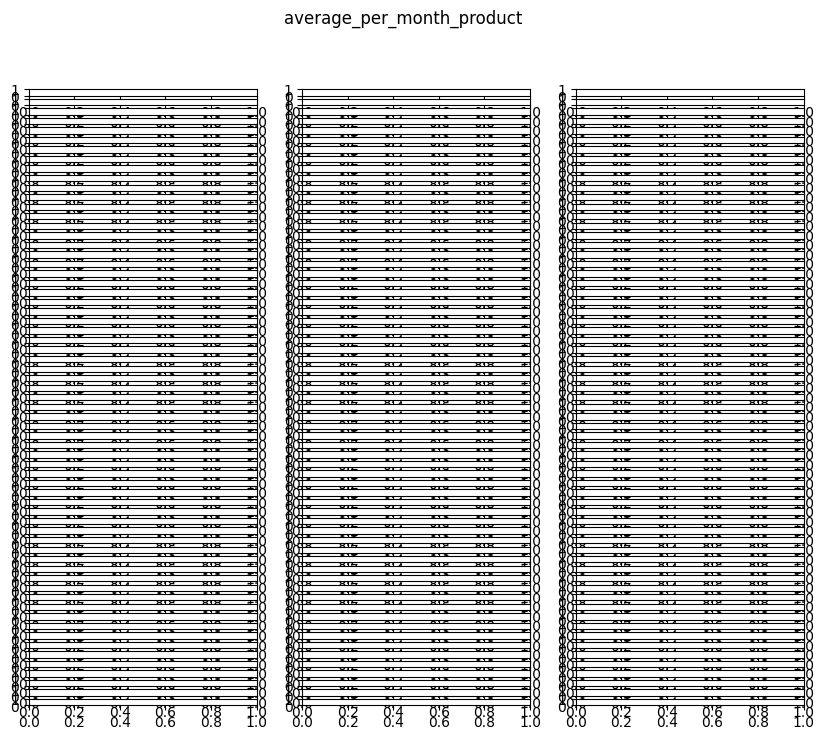

In [282]:
average_per_month_product(stats)

In [ ]:
items_sold(stats_2020, stats_2021, stats_2022, stats_2023, stats_2024)

client_sold(stats_2020, stats_2021, stats_2022, stats_2023, stats_2024)

We sold a total of different products for 2020:  55 For 2021:  54 For 2022:  52 For 2023:  50 For 2024:  33
We have a total of different clients for 2020:  898 For 2021:  640 For 2022:  489 For 2023:  707 For 2024:  51


In [ ]:
stats_2020_l = stats_2020.loc[stats_2020["category"] == "Lubricantes"]
stats_2020_t = stats_2020.loc[stats_2020["category"] == "Tapas"]
stats_2020_g = stats_2020.loc[stats_2020["category"] == "Gorro/Mascarilla"]
stats_2020_f = stats_2020.loc[stats_2020["category"] == "Frascos"]

#array(['Tapas', 'Lubricantes', 'Gorro/Mascarilla', 'Frascos', 'Anulación',
#       'Alquiler', 'Pets', 'Despacho'], dtype=object